In [1]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [1]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [3]:
imdb

{'train': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'test': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>}

In [8]:
train_data, test_data = imdb['train'], imdb['test']

In [33]:
tokenizer = info.features['text'].encoder

In [ ]:
print(tokenizer.subwords)

In [11]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [12]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [32]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

AttributeError: 'Tokenizer' object has no attribute 'vocab_size'

In [15]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 22s 52ms/step - loss: 0.6896 - accuracy: 0.5506 - val_loss: 0.6797 - val_accuracy: 0.5144
Epoch 2/10
391/391 [==============================] - 20s 51ms/step - loss: 0.6362 - accuracy: 0.6932 - val_loss: 0.5903 - val_accuracy: 0.7735
Epoch 3/10
391/391 [==============================] - 17s 43ms/step - loss: 0.5258 - accuracy: 0.8200 - val_loss: 0.4902 - val_accuracy: 0.8351
Epoch 4/10
391/391 [==============================] - 18s 46ms/step - loss: 0.4137 - accuracy: 0.8734 - val_loss: 0.3717 - val_accuracy: 0.8645
Epoch 5/10
391/391 [==============================] - 22s 57ms/step - loss: 0.2977 - accuracy: 0.8938 - val_loss: 0.3218 - val_accuracy: 0.8746
Epoch 6/10
391/391 [==============================] - 20s 51ms/step - loss: 0.2499 - accuracy: 0.9093 - val_loss: 0.3104 - val_accuracy: 0.8764
Epoch 7/10
391/391 [==============================] - 21s 55ms/step - loss: 0.2273 - accuracy: 0.9172 - val_loss: 0.3213 - val_accuracy:

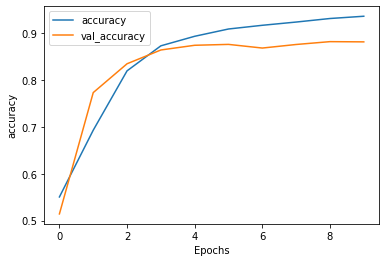

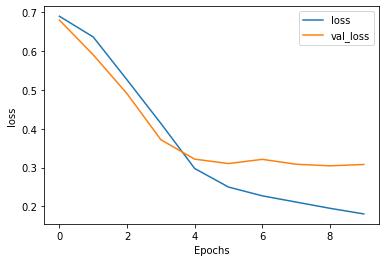

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Guardar Embbedings

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

(8185, 64)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LSTM

In [27]:
import numpy as np

In [19]:
predictions = model.predict(test_dataset)
predictions

array([[0.27478904],
       [0.99435735],
       [0.03558931],
       ...,
       [0.00762209],
       [0.9694978 ],
       [0.8668275 ]], dtype=float32)

In [20]:
model.predict(test_dataset)

TypeError: 'PaddedBatchDataset' object is not subscriptable

In [18]:
tokenizer.decode('s')

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [21]:
testing_sentences = []
testing_labels = []

for s, l in test_data.as_numpy_iterator():
  testing_sentences.append(s)
  testing_labels.append(l)

In [22]:
def predict_sentence(row_number):
  text = tokenizer.decode(testing_sentences[row_number])
  print("Valor real:", testing_labels[row_number], "Probabilidad predicha:", predictions[row_number])
  return text

In [24]:
predict_sentence(1000)

Valor real: 0 Probabilidad predicha: [0.60102147]


'I saw this movie many years ago, and just for kicks decided to rent it and watch it again. The plot is a carbon copy from Fright Night. I did like the hairy vampire and the bug eating driver. Otherwise it was not good at all.'

# Crear nuestro propio Tokenizer

In [27]:
import numpy as np

In [28]:
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data.as_numpy_iterator():
  training_sentences.append(str(s))
  training_labels.append(l)
  
for s,l in test_data.as_numpy_iterator():
  testing_sentences.append(str(s))
  testing_labels.append(l)
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [29]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [30]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

12 31 93 867 7 1256 6585 7961 421 365 2 26 14 9 988 1089 7 4 6728 6 276 5760 2587 2 81 6118 8029 2 139 1892 7961 5 5402 246 25 1 1771 350 5 369 56 5397 102 4 2547 3 4001 25 14 7822 209 12 3531 6585 7961 99 1 32 18 4762 3 19 184 3223 18 5855 1045 3 4232 3337 64 1347 5 1190 3 4459 8 614 7 3129 2 26 22 84 7020 6 71 18 4924 1160 161 50 2265 3 12 3983 2 12 264 31 2545 261 6 1 66 2 26 131 393 1 5846 6 15 5 473 56 614 7 1470 6
[  12   31   93  867    7 1256 6585 7961  421  365    2   26   14    9
  988 1089    7    4 6728    6  276 5760 2587    2   81 6118 8029    2
  139 1892 7961    5 5402  246   25    1 1771  350    5  369   56 5397
  102    4 2547    3 4001   25   14 7822  209   12 3531 6585 7961   99
    1   32   18 4762    3   19  184 3223   18 5855 1045    3 4232 3337
   64 1347    5 1190    3 4459    8  614    7 3129    2   26   22   84
 7020    6   71   18 4924 1160  161   50 2265    3   12 3983    2   12
  264   31 2545  261    6    1   66    2   26  131  393    1 5846    6
   15   

# Creación de un modelo [TO DO]

In [44]:
embedding_dim = 64

modelLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.LSTM(4),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 64)          523840    
                                                                 
 lstm_5 (LSTM)               (None, 4)                 1104      
                                                                 
 dense_12 (Dense)            (None, 6)                 30        
                                                                 
 dense_13 (Dense)            (None, 1)                 7         
                                                                 
Total params: 524,981
Trainable params: 524,981
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10

modelLSTM.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

historyLSTM = modelLSTM.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

In [52]:
embedding_dim = 64

modelGRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.SimpleRNN(128),    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelGRU.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 64)          523840    
                                                                 
 gru_4 (GRU)                 (None, None, 128)         74496     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 631,361
Trainable params: 631,361
Non-trainable params: 0
_________________________________________________________________


In [53]:
num_epochs = 10

modelGRU.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

modelGRU = modelGRU.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
140/391 [=========>....................] - ETA: 28:45 - loss: 0.7005 - accuracy: 0.5027

In [ ]:
embedding_dim = 64

modelGRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modelGRU.summary()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')